### *Libraries and functions*

In [1]:
from collections.abc import Sequence
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
import os
import pickle
from sklearn.metrics import roc_curve, auc

# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)

# Encode text values to a single dummy variable.  The new columns (which do not replace the old) will have a 1
# at every location where the original column (name) matches each of the target_values.  One column is added for
# each target value.
def encode_text_single_dummy(df, name, target_values):
    for tv in target_values:
        l = list(df[name].astype(str))
        l = [1 if str(x) == str(tv) else 0 for x in l]
        name2 = "{}-{}".format(name, tv)
        df[name2] = l


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column.
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low
    
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('Actual')
    plt.xlabel('Predicted')

def plot_roc(pred,y):
    fpr, tpr, thresholds = roc_curve(y, pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

### Loading Preprocessed Testing and Training Data

In [2]:
training_data =pd.read_pickle("./data/training_index.pkl")
training_data.head()

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,label
0,-0.213726,117,0,4,-0.124454,-0.151815,-0.043683,-0.087368,0.057181,0.719436,...,-0.468309,-0.450184,-0.477991,0,-0.090617,-0.203142,-0.640029,-0.644186,0,0
1,-0.213727,117,0,4,-0.124454,-0.151815,-0.036308,-0.087368,0.286563,0.719436,...,-0.468309,-0.450184,-0.477991,0,-0.090617,-0.203142,-0.640029,-0.644186,0,0
2,-0.213727,117,0,4,-0.124454,-0.151815,-0.040351,-0.087368,0.791205,0.719436,...,-0.468309,-0.450184,-0.390389,0,-0.090617,-0.203142,-0.640029,-0.554270,0,0
3,-0.213727,117,0,4,-0.124454,-0.151815,-0.041330,-0.087368,0.566919,0.719436,...,-0.349113,-0.450184,-0.390389,0,-0.090617,-0.203142,-0.522987,-0.554270,0,0
4,-0.213726,117,0,4,-0.124454,-0.151815,-0.034187,-0.087368,0.118349,0.719436,...,-0.349113,-0.450184,-0.390389,0,-0.090617,-0.203142,-0.522987,-0.554270,0,0


In [3]:
testing_data = pd.read_pickle("./data/testing_index.pkl")
testing_data.head()

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,label
0,-0.191028,113,0,2,-0.104456,-0.135768,-0.049133,-0.102725,-0.576370,0.703837,...,-0.544735,-0.554372,-0.705527,0,-0.118590,-0.189768,-0.715712,-0.753072,0,0
1,-0.109484,113,0,2,-0.046013,0.172598,-0.046410,0.188544,-0.576343,-1.141898,...,-0.544735,-0.554372,-0.614254,0,-0.118590,-0.189768,-0.715712,-0.288256,0,0
2,0.040699,113,0,2,-0.089845,-0.026933,-0.048527,-0.012133,-0.576732,-1.141898,...,-0.544735,-0.554372,-0.522981,0,-0.118590,-0.189768,-0.595541,-0.288256,0,0
3,0.049729,113,3,2,-0.060624,-0.063212,-0.047016,-0.098562,-0.576735,-1.141898,...,-0.544735,-0.554372,-0.522981,1,7.814893,-0.189768,-0.595541,-0.753072,0,0
4,-0.140417,113,0,2,-0.075234,-0.117629,-0.047554,-0.102057,-0.576616,0.723266,...,-0.420467,-0.554372,2.854106,0,-0.118590,-0.189768,-0.595541,2.779527,0,0


### Converting training and test data into X, Y

In [4]:
X_Train = training_data.drop('label', axis = 1)
Y_Train = training_data['label']

In [5]:
X_Train

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports
0,-0.213726,117,0,4,-0.124454,-0.151815,-0.043683,-0.087368,0.057181,0.719436,...,-0.563656,-0.468309,-0.450184,-0.477991,0,-0.090617,-0.203142,-0.640029,-0.644186,0
1,-0.213727,117,0,4,-0.124454,-0.151815,-0.036308,-0.087368,0.286563,0.719436,...,-0.563656,-0.468309,-0.450184,-0.477991,0,-0.090617,-0.203142,-0.640029,-0.644186,0
2,-0.213727,117,0,4,-0.124454,-0.151815,-0.040351,-0.087368,0.791205,0.719436,...,-0.563656,-0.468309,-0.450184,-0.390389,0,-0.090617,-0.203142,-0.640029,-0.554270,0
3,-0.213727,117,0,4,-0.124454,-0.151815,-0.041330,-0.087368,0.566919,0.719436,...,-0.444865,-0.349113,-0.450184,-0.390389,0,-0.090617,-0.203142,-0.522987,-0.554270,0
4,-0.213726,117,0,4,-0.124454,-0.151815,-0.034187,-0.087368,0.118349,0.719436,...,-0.444865,-0.349113,-0.450184,-0.390389,0,-0.090617,-0.203142,-0.522987,-0.554270,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82327,-0.213727,117,0,4,-0.124454,-0.151815,-0.045967,-0.087368,0.791205,0.719436,...,-0.444865,-0.468309,-0.450184,-0.477991,0,-0.090617,-0.203142,-0.522987,-0.734103,0
82328,0.021090,111,0,3,0.009958,-0.082596,0.058657,-0.085031,-0.554342,0.719436,...,-0.444865,-0.468309,-0.450184,-0.565594,0,-0.090617,-0.203142,-0.405944,-0.644186,0
82329,-0.213728,6,0,4,-0.131922,-0.151815,-0.046305,-0.087368,-0.554506,-1.782698,...,-0.563656,-0.468309,-0.450184,-0.565594,0,-0.090617,-0.203142,-0.640029,-0.734103,1
82330,-0.213728,6,0,4,-0.131922,-0.151815,-0.046305,-0.087368,-0.554506,-1.782698,...,-0.563656,-0.468309,-0.450184,-0.565594,0,-0.090617,-0.203142,-0.640029,-0.734103,1


In [6]:
Y_Train

0        0
1        0
2        0
3        0
4        0
        ..
82327    0
82328    0
82329    0
82330    0
82331    0
Name: label, Length: 82332, dtype: int64

In [7]:
X_Test = testing_data.drop('label', axis = 1)
Y_Test = testing_data['label']

In [8]:
X_Test

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports
0,-0.191028,113,0,2,-0.104456,-0.135768,-0.049133,-0.102725,-0.576370,0.703837,...,-0.645011,-0.544735,-0.554372,-0.705527,0,-0.118590,-0.189768,-0.715712,-0.753072,0
1,-0.109484,113,0,2,-0.046013,0.172598,-0.046410,0.188544,-0.576343,-1.141898,...,-0.645011,-0.544735,-0.554372,-0.614254,0,-0.118590,-0.189768,-0.715712,-0.288256,0
2,0.040699,113,0,2,-0.089845,-0.026933,-0.048527,-0.012133,-0.576732,-1.141898,...,-0.520826,-0.544735,-0.554372,-0.522981,0,-0.118590,-0.189768,-0.595541,-0.288256,0
3,0.049729,113,3,2,-0.060624,-0.063212,-0.047016,-0.098562,-0.576735,-1.141898,...,-0.520826,-0.544735,-0.554372,-0.522981,1,7.814893,-0.189768,-0.595541,-0.753072,0
4,-0.140417,113,0,2,-0.075234,-0.117629,-0.047554,-0.102057,-0.576616,0.723266,...,-0.520826,-0.420467,-0.554372,2.854106,0,-0.118590,-0.189768,-0.595541,2.779527,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175336,-0.209773,119,2,3,-0.133677,-0.172047,-0.049957,-0.103923,0.094951,0.723266,...,2.211253,2.313436,1.520466,1.393744,0,-0.118590,-0.189768,2.048216,1.385080,0
175337,-0.131727,113,0,2,-0.075234,-0.099490,-0.047062,-0.101458,-0.576614,0.723266,...,-0.645011,-0.544735,-0.554372,-0.614254,0,-0.118590,-0.189768,-0.715712,-0.753072,0
175338,-0.209773,119,2,3,-0.133677,-0.172047,-0.049957,-0.103923,0.094951,0.723266,...,-0.396640,-0.296198,-0.208565,0.389745,0,-0.118590,-0.189768,-0.475370,0.269523,0
175339,-0.209773,119,2,3,-0.133677,-0.172047,-0.049957,-0.103923,0.094951,0.723266,...,2.956366,3.059046,1.693369,1.941380,0,-0.118590,-0.189768,2.769240,1.942859,0


In [9]:
Y_Train

0        0
1        0
2        0
3        0
4        0
        ..
82327    0
82328    0
82329    0
82330    0
82331    0
Name: label, Length: 82332, dtype: int64

### Training the Logistic Regression Model

In [10]:
from sklearn.linear_model import LogisticRegression
import joblib 

clf = LogisticRegression(C = 1, max_iter= 10000)
clf.fit(X_Train,Y_Train)

LR_Model = joblib.dump(clf, './models/LR_Model')

### Load the model(Can start from here, must load X and Y Test.)

In [11]:
import joblib
clf = joblib.load("./models/LR_Model")
LR_Predictions = clf.predict(X_Test)

### Looking at Accuracy, F1_Score, Precision

In [12]:
from sklearn.metrics import accuracy_score, f1_score, precision_score

accuracy = accuracy_score(Y_Test, LR_Predictions)
f1 = f1_score(Y_Test, LR_Predictions)
precision = precision_score(Y_Test, LR_Predictions)
print('Accuracy: {}\nF1_Score: {}\nPrecision: {}\n'.format(accuracy, f1, precision))

Accuracy: 0.6645907118129816
F1_Score: 0.6745361070066797
Precision: 0.9932527135825809



In [13]:
results = pd.concat([Y_Test, pd.Series(LR_Predictions)], axis = 1)
results.columns = ["Actual Label", "Predicted Label"]
results.head(10)

,Actual Label,Predicted Label
0,0,0
1,0,1
2,0,1
3,0,0
4,0,0
5,0,0
6,0,0
7,0,0
8,0,0
9,0,0


### Confusion Matrix

[[55586   414]
 [58397 60944]]
              precision    recall  f1-score   support

           0       0.49      0.99      0.65     56000
           1       0.99      0.51      0.67    119341

    accuracy                           0.66    175341
   macro avg       0.74      0.75      0.66    175341
weighted avg       0.83      0.66      0.67    175341



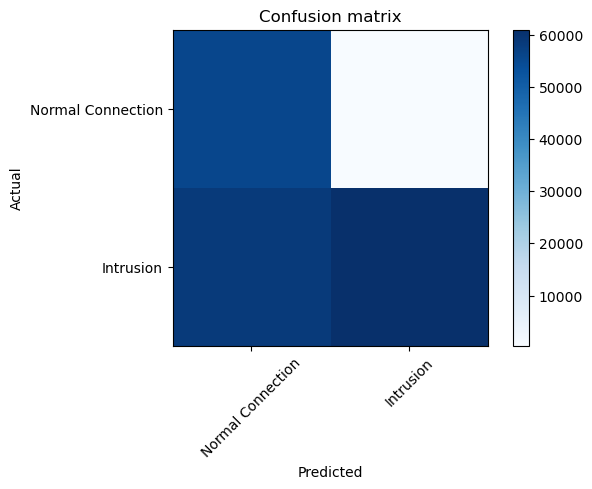

In [14]:
from sklearn.metrics import confusion_matrix, classification_report

confusion = confusion_matrix(Y_Test, LR_Predictions)
print(confusion)

print(classification_report(Y_Test, LR_Predictions))
plot_confusion_matrix(confusion, ['Normal Connection', 'Intrusion'], title='Confusion matrix', cmap=plt.cm.Blues)

### ROC Graph

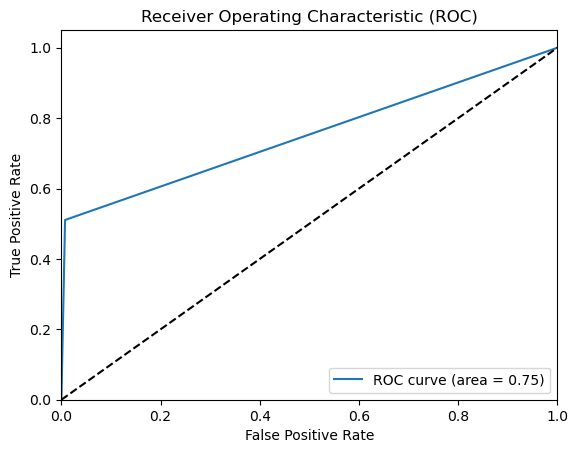

In [15]:
plot_roc(LR_Predictions, Y_Test)